<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1TRNaCfYstvcIQqoUSdukYQGF6LuyL7Tv" width=600 height=320/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

# Домашнее задание. Автоэнкодеры


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (1 балл)


In [1]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt

import os
import pandas as pd
import skimage.io
from skimage.transform import resize
import torchvision.transforms as transforms

%matplotlib inline

In [2]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos, all_attrs

In [3]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind


data, attrs = fetch_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done



Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [4]:
from sklearn.model_selection import train_test_split
train_img, val_img, train_attr, val_attr = train_test_split(data, attrs, train_size = 0.9, shuffle = False)

# plt.figure(figsize=(15,5))
# for i in range(5):
#     plt.subplot(2, 6, i + 1)
#     plt.axis('off')
#     plt.imshow(train_img[i])

#     plt.subplot(2, 6, i + 7)
#     plt.axis('off')
#     plt.imshow(val_img[i])
# plt.show()

In [5]:
from torch.utils.data import DataLoader

X_data_train = DataLoader(torch.from_numpy(np.rollaxis(train_img, 3, 1)), shuffle=True)
X_data_val = DataLoader(torch.from_numpy(np.rollaxis(val_img, 3, 1)), shuffle=True)

## 1.2. Архитектура модели (2 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

In [ ]:
dim_code = 512 # выберите размер латентного вектора

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [ ]:
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(4096, dim_code)
        )

        self.decoder = nn.Sequential(
            nn.Linear(dim_code, 4096),
            nn.ReLU(),
            nn.Unflatten(1, (64, 8, 8)),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        # Обратите внимание на формат, в котором функция fetch() возвращает data

    def forward(self, x):
        # реализуйте forward проход автоэнкодера
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)
        return reconstruction, latent_code
    def sampling(self, x):
        generated = self.decoder(x)
        return generated

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

loss_fn = nn.MSELoss()
model = Autoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
for batch in X_data_train:
    print(batch.shape)

  0%|          | 0/15 [00:00<?, ?it/s]

epoch: 0, 
train loss: 0.008707674595473494 
val loss: 0.004784059752554471
epoch: 1, 
train loss: 0.004095470358053519 
val loss: 0.00350284865543552
epoch: 2, 
train loss: 0.0032005117756781025 
val loss: 0.002958691439741379
epoch: 3, 
train loss: 0.0027537182646910326 
val loss: 0.002666319830139312
epoch: 4, 
train loss: 0.0024266614537168953 
val loss: 0.0023052888734147268
epoch: 5, 
train loss: 0.002141407908300756 
val loss: 0.0021916978152491445
epoch: 6, 
train loss: 0.0019663866555950037 
val loss: 0.002047881774185367
epoch: 7, 
train loss: 0.0018284628374634659 
val loss: 0.0019142567378250843
epoch: 8, 
train loss: 0.001700813856521841 
val loss: 0.0017801530910075548
epoch: 9, 
train loss: 0.001602811850657788 
val loss: 0.0016598775016857272
epoch: 10, 
train loss: 0.001508348601270879 
val loss: 0.0015505645463050634
epoch: 11, 
train loss: 0.0014287676243079997 
val loss: 0.0014801803320974654
epoch: 12, 
train loss: 0.001383229138720642 
val loss: 0.0014531574157876

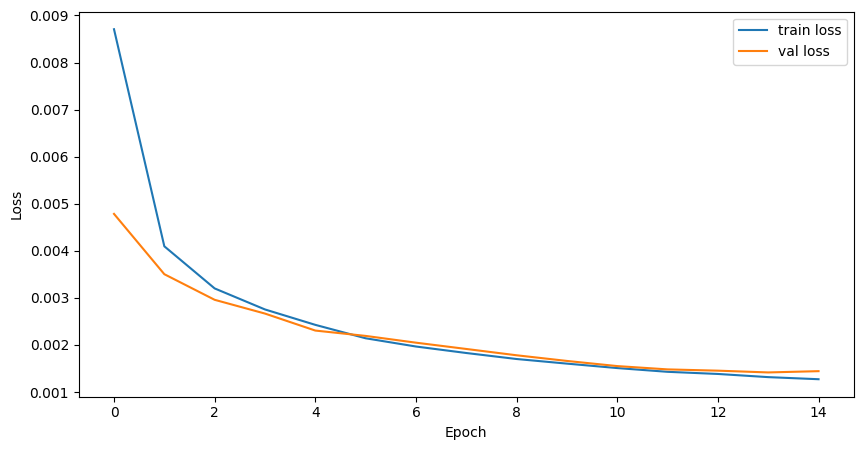

In [ ]:
from tqdm.notebook import tqdm
n_epochs = 15
train_loss = []
val_loss = []
for epoch in tqdm(range(n_epochs)):
    model.train()
    train_loss_per_epoch = []
    for X_batch in X_data_train:
        optimizer.zero_grad()
        X_batch = X_batch.float().to(device)
        reconstructed, latented = model(X_batch)
        loss = loss_fn(reconstructed, X_batch)
        loss.backward()
        optimizer.step()
        train_loss_per_epoch.append(loss.item())
        torch.cuda.empty_cache()
    train_loss.append(np.mean(train_loss_per_epoch))

    model.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for X_batch in X_data_val:
            X_batch = X_batch.float().to(device)
            reconstructed, latented = model(X_batch)
            loss = loss_fn(reconstructed, X_batch)
            val_losses_per_epoch.append(loss.item())
    reconstructed = reconstructed.cpu()
    X_batch = X_batch.cpu()

    if device == 'cuda':
        torch.cuda.empty_cache()

    val_loss.append(np.mean(val_losses_per_epoch))
    print(f'epoch: {epoch}, \ntrain loss: {train_loss[-1]} \nval loss: {val_loss[-1]}')
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

ORIGIN:


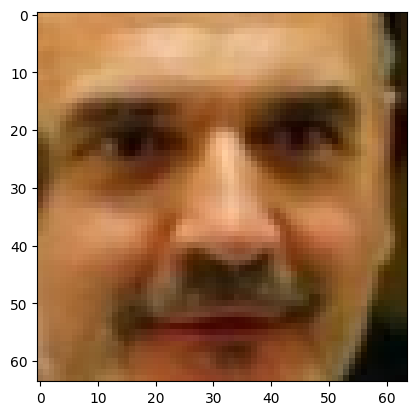


RECONSTRUCT:


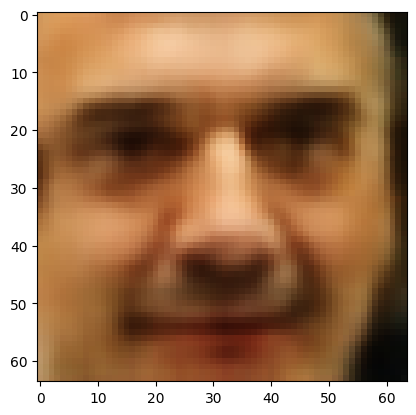

ORIGIN:


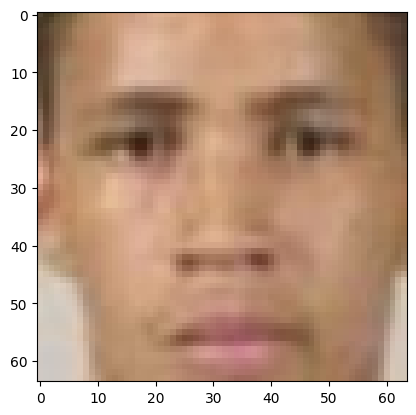


RECONSTRUCT:


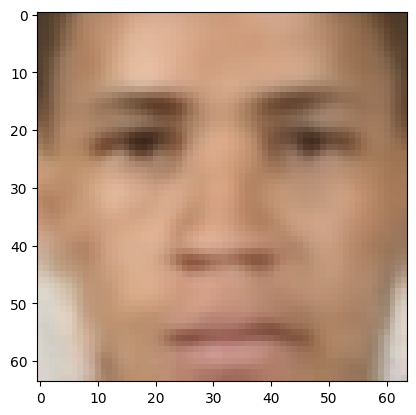

ORIGIN:


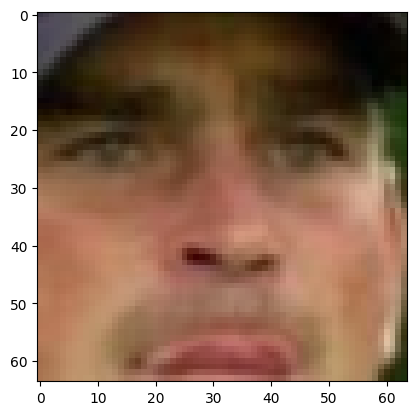


RECONSTRUCT:


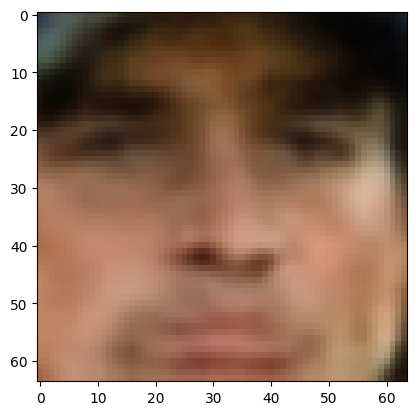

ORIGIN:


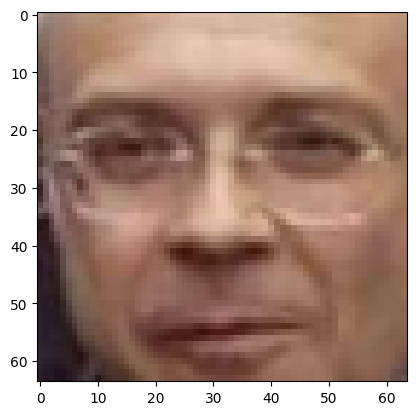


RECONSTRUCT:


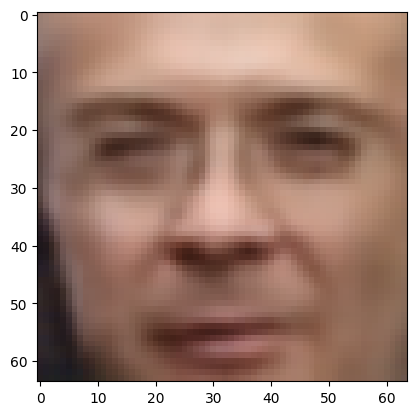

In [ ]:
batch_size = 4
model.eval()
for i, X_batch in enumerate(X_data_val):
    X_batch = X_batch.float().to(device)
    output = model(X_batch)
    reconstructed = output[0].detach().to('cpu').reshape(4, 3, 64, 64)
    X_batch = X_batch.to('cpu')
    for i in range(batch_size):
        print('ORIGIN:')
        plt.imshow(X_batch[i].permute(1, 2, 0))
        plt.show()
        print('\nRECONSTRUCT:')
        plt.imshow(reconstructed[i].permute(1, 2, 0))
        plt.show()
    if i>0: break

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

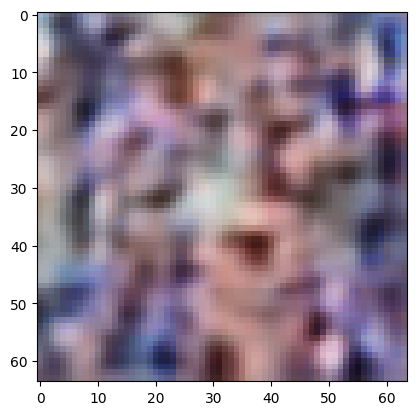

In [ ]:
z = np.random.randn(25, dim_code)
output = model.sampling(torch.FloatTensor(z).to(device))
plt.imshow(output[0].permute(1, 2, 0).cpu().detach().numpy())

In [ ]:
latent_codes=[]
model.eval()
for i, X_train in enumerate(X_data_val):
    X_train = X_train.float().to(device)
    outputs = model(X_train)
    if len(outputs[1]) == 4:
        latent_codes.append(outputs[1][0])
        latent_codes.append(outputs[1][1])
        latent_codes.append(outputs[1][2])
        latent_codes.append(outputs[1][3])

In [ ]:
def gen_lat_repr():
    latent_code=np.zeros(dim_code)
    for coord in range(dim_code):
        # Возьмем i-ю координату из случайного вектора из латентного пространства
        i = np.random.randint(0, len(latent_codes))
        print(latent_code)
        latent_code[coord] = latent_codes[i][coord]
    return latent_code

In [ ]:
z = np.zeros((25, dim_code))
for i in range(25):
    z[i] = gen_lat_repr()

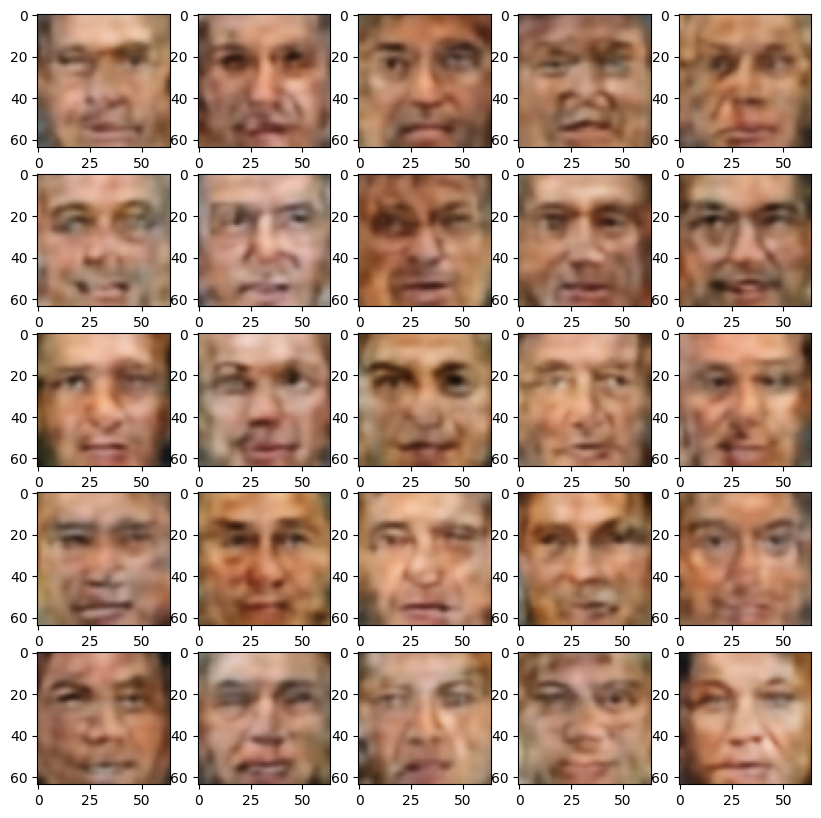

In [ ]:
output = model.sampling(torch.FloatTensor(z).to(device))
plt.figure(figsize=(10, 10))
for i in range(output.shape[0]):
    plt.subplot(5, 5, i + 1)
    generated = output[i].cpu().detach().numpy()
    generated = np.transpose(generated, (1, 2, 0))
    plt.imshow(generated)
plt.show()

## 1.5 Time to make fun! (3 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [ ]:
smile_index = train_attr.sort_values(by='Smiling', ascending=False).head(30).index
smile_data = train_img[smile_index]
smile_data = np.transpose(smile_data, (0, 3, 1, 2))

sad_index = train_attr.sort_values(by='Smiling', ascending=False).tail(30).index
sad_data = train_img[sad_index]
sad_data = np.transpose(sad_data, (0, 3, 1, 2))

In [ ]:
# for i in smile_index[:5]:
#     plt.imshow(train_img[i])
#     plt.show()

In [ ]:
# for i in sad_index[:5]:
#   plt.imshow(train_img[i])
#   plt.show()

In [ ]:
smile_data_t = torch.from_numpy(smile_data).float()
sad_data_t = torch.from_numpy(sad_data).float()

model.eval()
with torch.no_grad():
    latent_smile = model.encoder(smile_data_t.to(device))
    latent_sad = model.encoder(sad_data_t.to(device))

latent_smile_encoded = latent_smile.detach().to('cpu').mean(0)
latent_sad_encoded = latent_sad.detach().to('cpu').mean(0)

In [ ]:
smile_direction = latent_smile_encoded - latent_sad_encoded

In [ ]:
with torch.no_grad():
    forced_smile = model.decoder(smile_direction.to(device)+latent_sad)

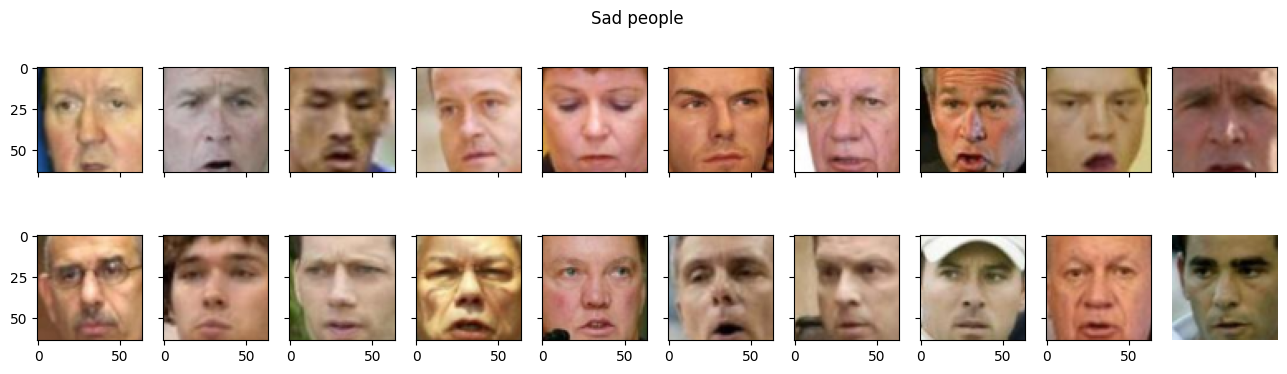

In [ ]:
fig, ax = plt.subplots(2, 10, figsize=(16, 4), sharey=True, sharex=True)
for i, fig_x in enumerate(ax.flatten()):
    fig_x.imshow(data[sad_index[i]])
    plt.axis('off')
plt.suptitle('Sad people')
plt.show()

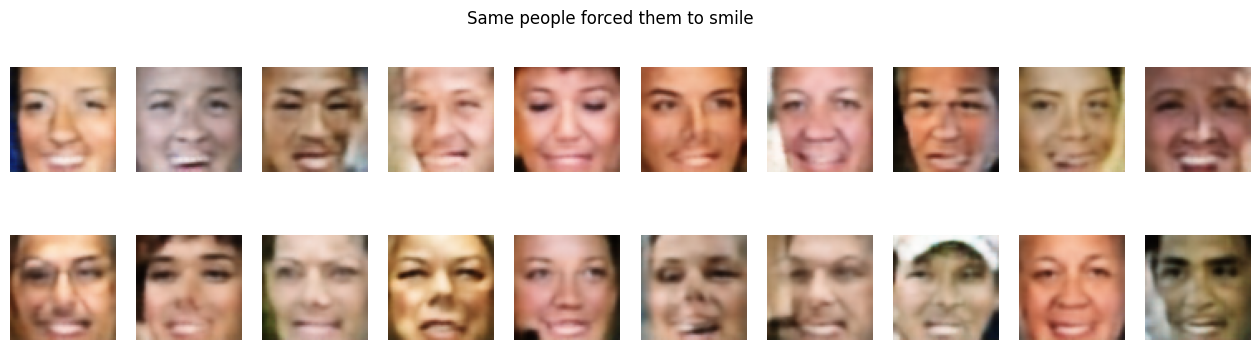

In [ ]:
fig, ax = plt.subplots(2, 10, figsize=(16, 4))
for i in range(20):
    plt.subplot(2, 10, i+1)
    plt.imshow(forced_smile[i].to('cpu').permute(1,2,0))
    plt.axis('off')
plt.suptitle('Same people forced them to smile')
plt.show()

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов)

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [5]:
from torch.utils.data import DataLoader
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 177848027.53it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 21577430.32it/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 40607903.26it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 4819258.48it/s]


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



In [6]:
# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size=batch_size, shuffle=False)

## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [7]:
class VAE(nn.Module):
    # <определите архитектуры encoder и decoder
    # помните, у encoder должны быть два "хвоста",
    # т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>
    def __init__(self):
        super(VAE, self).__init__()
        self.latent_dim = 32

        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, self.latent_dim * 2)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, 784),
            nn.Sigmoid()
        )

    def encode(self, x):
        encoded = self.encoder(x)
        mu = encoded[:, :self.latent_dim]
        logsigma = encoded[:, self.latent_dim:]
        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            # <засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>
            std = torch.exp(0.5 * logsigma)
            return mu + torch.randn_like(std) * std
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, z):
        # <реализуйте forward проход декодера
        # в качестве возвращаемой переменной -- reconstruction>
        reconstruction = self.decoder(z)
        return reconstruction

    def forward(self, x):
        # <используя encode и decode, реализуйте forward проход автоэнкодера
        # в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
        x = x.view(-1, 784)
        mu, logsigma = self.encode(x)
        sample = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(sample)
        return reconstruction, mu, logsigma


Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [8]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    # loss = <напишите код для KL-дивергенции, пользуясь формулой выше>
    loss = -0.5 * torch.sum(1 + logsigma - pow(mu, 2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    # loss = <binary cross-entropy>
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x.view(-1, 784))

def loss_vae(x, mu, logsigma, reconstruction):
    BCE = log_likelihood(x, reconstruction)
    KLD = KL_divergence(mu, logsigma)
    return BCE + KLD
    # <соедините тут две компоненты лосса. Mind the sign!>

И обучим модель:

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

criterion = loss_vae

vautoencoder = VAE().to(device)

optimizer = torch.optim.AdamW(vautoencoder.parameters())

In [14]:
# <обучите модель на датасете MNIST>
from IPython.display import display, clear_output
from IPython import display
history = {'epoch': [], 'train_loss': [], 'val_loss': []}
from tqdm.notebook import tqdm
n_epochs = 30
train_losses = []
val_losses = []
for epoch in tqdm(range(n_epochs)):
    vautoencoder.train()
    train_loss_per_epoch = []
    for (image, attr) in train_loader:
        optimizer.zero_grad()
        image = image.to(device)
        out, mu, logvar = vautoencoder(image)
        loss = criterion(image, mu, logvar, out)
        loss.backward()
        optimizer.step()
        train_loss_per_epoch.append(loss.item())
    train_losses.append(np.mean(train_loss_per_epoch))
    print(np.mean(train_loss_per_epoch))
    vautoencoder.eval()
    val_loss_per_epoch = []
    with torch.no_grad():
        for (image, attr) in train_loader:
            image = image.to(device)
            out, mu, logvar = vautoencoder(image)
            loss = criterion(image, mu, logvar, out)
            val_loss_per_epoch.append(loss.item())
    # val_losses.append()
    history['epoch'].append(epoch)
    history['train_loss'].append(np.mean(train_loss_per_epoch))
    history['val_loss'].append(np.mean(val_loss_per_epoch))

  0%|          | 0/30 [00:00<?, ?it/s]

4949.760215885417
3961.0704161458334
3827.4900815104165
3760.5835873697915
3713.905626041667
3678.117444921875
3651.592304296875
3630.68716484375
3611.200168489583
3590.8078647135417
3572.9869177083333
3571.2356733072916
3558.7961240885415
3543.9429869791666
3536.5718666666667
3527.356849088542
3520.8364384114584
3510.6225475260417
3503.900751822917
3500.5545140625
3493.9528947916665
3489.3287734375
3483.698791796875
3476.889512760417
3469.8233997395832
3467.352642447917
3462.160830859375
3458.9737283854165
3461.1893877604166
3457.9217751302085


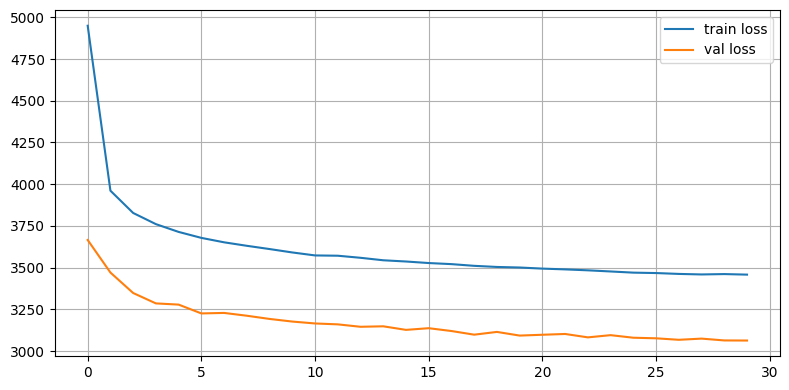

<Figure size 800x400 with 0 Axes>

In [15]:
plt.figure(figsize=(8, 4))
plt.plot(history['epoch'], history['train_loss'], label='train loss')
plt.plot(history['epoch'], history['val_loss'], label='val loss')
plt.tight_layout()
plt.legend()
plt.grid()
display.display(plt.gcf())
        #plt.cla()
plt.clf()

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

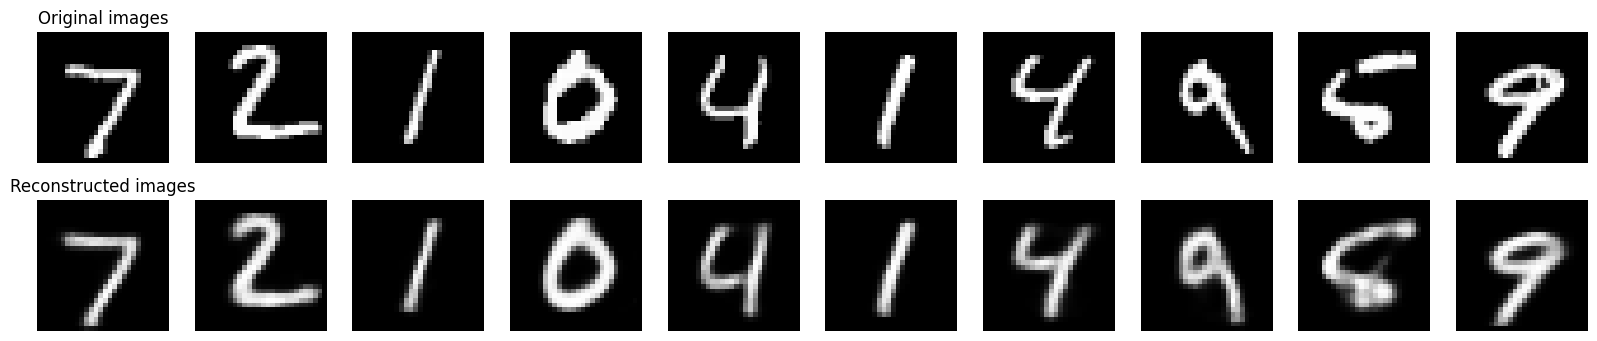

In [16]:
# < тут Ваш код: выведите первые Х картинок и их реконструкций из val выборки на экран>
fig, axes = plt.subplots(2, 10, figsize=(20, 4))
for images, _ in test_loader:
    imgs, _, _ = vautoencoder(images.to(device))
    for i in range(10):
        axes[0, i].imshow(images[i].detach().cpu().numpy().reshape(28, 28), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(imgs[i].detach().cpu().numpy().reshape(28, 28), cmap='gray')
        axes[1, i].axis('off')
    break
axes[0, 0].set_title('Original images')
axes[1, 0].set_title('Reconstructed images')
plt.show()

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

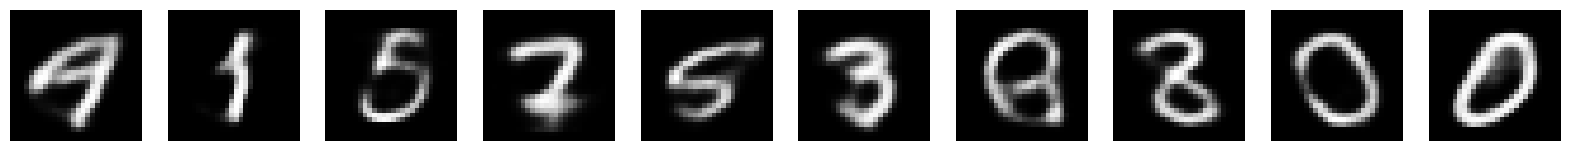

In [17]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
vautoencoder = vautoencoder.cpu()
vautoencoder.eval()
z = np.array([np.random.normal(0, 1, 32) for i in range(10)])
output = vautoencoder.decode(torch.FloatTensor(z))
output = output.cpu().detach().numpy()
plt.figure(figsize=(20, 2))
for i in range(output.shape[0]):
    plt.subplot(1, 10, i + 1)
    plt.imshow(output[i].reshape(28, 28), cmap = 'gray')
    plt.axis('off')
plt.show()

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве.

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве.

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

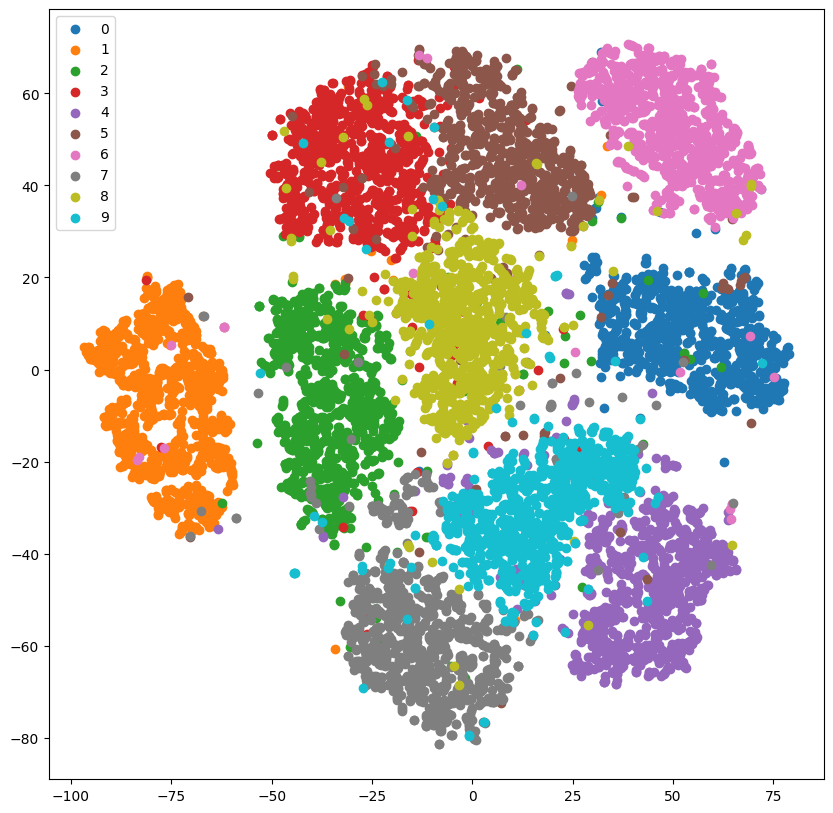

In [19]:
# <ваш код получения латентных представлений, применения TSNE и визуализации>
from sklearn.manifold import TSNE

latent_vectors = []
colors = []
vautoencoder.eval()
vautoencoder.to(device)
with torch.no_grad():
    for i, (image, attr) in enumerate(test_loader):
        image = image.to(device)
        mu, logvar = vautoencoder.encode(image)
        gaus_samp = vautoencoder.gaussian_sampler(mu, logvar)
        latent_vectors.append(gaus_samp.cpu().numpy())
        colors.append(attr.cpu().numpy())
latent_vectors = np.concatenate(latent_vectors, axis=0)
colors = np.concatenate(colors, axis=0)

tsne = TSNE(n_components=2)
latent_vectors_tsne = tsne.fit_transform(latent_vectors)

plt.figure(figsize = (10, 10))
for i in range(10):
    plt.scatter(latent_vectors_tsne[colors == i, 0], latent_vectors_tsne[colors == i, 1], label = str(i))
plt.legend()
plt.show()

Что вы думаете о виде латентного представления?

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер.
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица).
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки.

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [52]:
class CVAE(nn.Module):
    def __init__(self):
        # <определите архитектуры encoder и decoder
        # помните, у encoder должны быть два "хвоста",
        # т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>
        super(CVAE, self).__init__()
        self.latent_dim = 32

        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784 + 10, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, self.latent_dim * 2)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim + 10, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, 784),
            nn.Sigmoid()
        )


    def encode(self, x, class_num):
        # <реализуйте forward проход энкодера
        # в качестве ваозвращаемых переменных -- mu, logsigma и класс картинки>
        concat_input = torch.cat([x.view(-1, 784), class_num], 1)
        encoded = self.encoder(concat_input)
        mu = encoded[:, :self.latent_dim]
        logsigma = encoded[:, self.latent_dim:]
        return mu, logsigma, class_num

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            # <засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>
            std = torch.exp(0.5 * logsigma)
            return mu + torch.randn_like(std) * std
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, z, class_num):
        # <реализуйте forward проход декодера
        # в качестве возвращаемой переменной -- reconstruction>
        concat_input = torch.cat([z, class_num], 1)
        reconstruction = self.decoder(concat_input)
        return reconstruction

    def forward(self, x, class_num):
        # <используя encode и decode, реализуйте forward проход автоэнкодера
        # в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
        mu, logsigma, class_num = self.encode(x, class_num)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z, class_num)
        return mu, logsigma, reconstruction

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

In [53]:
def one_hot(labels_batch):
    outputs = []
    for label in labels_batch:
        output = torch.zeros(10)
        output[label] = 1.0
        outputs.append(output)
    return torch.stack(outputs)

In [54]:
criterion = loss_vae

cvautoencoder = CVAE().to(device)

optimizer = torch.optim.AdamW(cvautoencoder.parameters())

In [55]:
# <обучите модель на датасете MNIST>
from IPython.display import display, clear_output
from IPython import display
history = {'epoch': [], 'train_loss': [], 'val_loss': []}
from tqdm.notebook import tqdm
n_epochs = 10
train_losses = []
val_losses = []
for epoch in tqdm(range(n_epochs)):
    cvautoencoder.train()
    train_loss_per_epoch = []
    for (image, attr) in train_loader:
        optimizer.zero_grad()
        class_num = one_hot(attr).to(device)
        image = image.to(device)
        mu, logvar, out = cvautoencoder(image, class_num)
        loss = criterion(image, mu, logvar, out)
        loss.backward()
        optimizer.step()
        train_loss_per_epoch.append(loss.item())
    train_losses.append(np.mean(train_loss_per_epoch))
    print(np.mean(train_loss_per_epoch))
    cvautoencoder.eval()
    val_loss_per_epoch = []
    with torch.no_grad():
        for (image, attr) in train_loader:
            class_num = one_hot(attr).to(device)
            image = image.to(device)
            mu, logvar, out = cvautoencoder(image, class_num)
            loss = criterion(image, mu, logvar, out)
            val_loss_per_epoch.append(loss.item())
    # val_losses.append()
    history['epoch'].append(epoch)
    history['train_loss'].append(np.mean(train_loss_per_epoch))
    history['val_loss'].append(np.mean(val_loss_per_epoch))

  0%|          | 0/10 [00:00<?, ?it/s]

4823.117057552084
3831.8015817708333
3687.7788807291668
3613.4605540364582
3558.89119375
3526.1084365885417
3498.746067578125
3467.656529427083
3451.3847701822915
3432.8533606770834


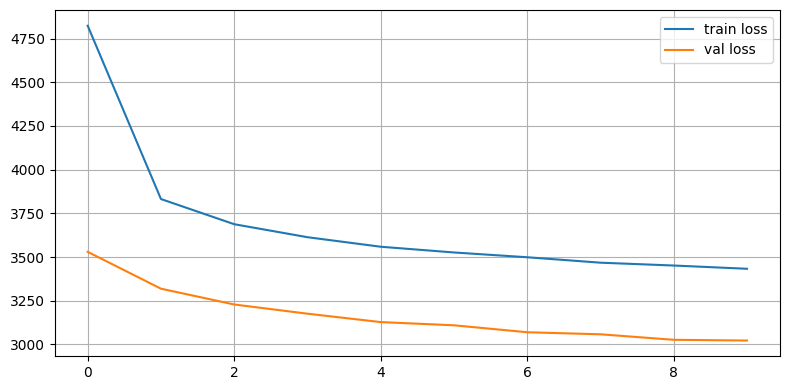

<Figure size 800x400 with 0 Axes>

In [56]:
plt.figure(figsize=(8, 4))
plt.plot(history['epoch'], history['train_loss'], label='train loss')
plt.plot(history['epoch'], history['val_loss'], label='val loss')
plt.tight_layout()
plt.legend()
plt.grid()
display.display(plt.gcf())
plt.clf()

In [57]:
numbers = one_hot([0,1,2,3,4,5,6,7,8,9])

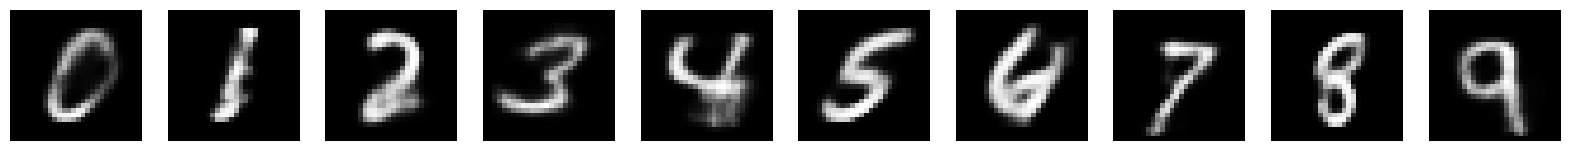

In [59]:
cvautoencoder = cvautoencoder.to(device)
cvautoencoder.eval()
z = np.array([np.random.normal(0, 1, 32) for i in range(10)])
output = cvautoencoder.decode(torch.FloatTensor(z).to(device), numbers.to(device))
output = output.cpu().detach().numpy()
plt.figure(figsize=(20, 2))
for i in range(output.shape[0]):
    plt.subplot(1, 10, i + 1)
    plt.imshow(output[i].reshape(28, 28), cmap = 'gray')
    plt.axis('off')
plt.show()

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [69]:
# <ваш код получения латентных представлений, применения TSNE и визуализации>
from sklearn.manifold import TSNE

latent_vectors = []
colors = []
cvautoencoder.eval()
cvautoencoder.to(device)
with torch.no_grad():
    for i, (image, labels) in enumerate(test_loader):
        image = image.to(device)
        class_num = one_hot(labels).to(device)
        if class_num.shape[0] != image.shape[0]:
            break
        mu, logvar, class_num = cvautoencoder.encode(image, class_num)
        gaus_samp = cvautoencoder.gaussian_sampler(mu, logvar)
        latent_vectors.append(gaus_samp.cpu().numpy())
        colors.append(labels.cpu().numpy())
latent_vectors = np.concatenate(latent_vectors, axis=0)
colors = np.concatenate(colors, axis=0)

tsne = TSNE(n_components=2)
latent_vectors_tsne = tsne.fit_transform(latent_vectors)

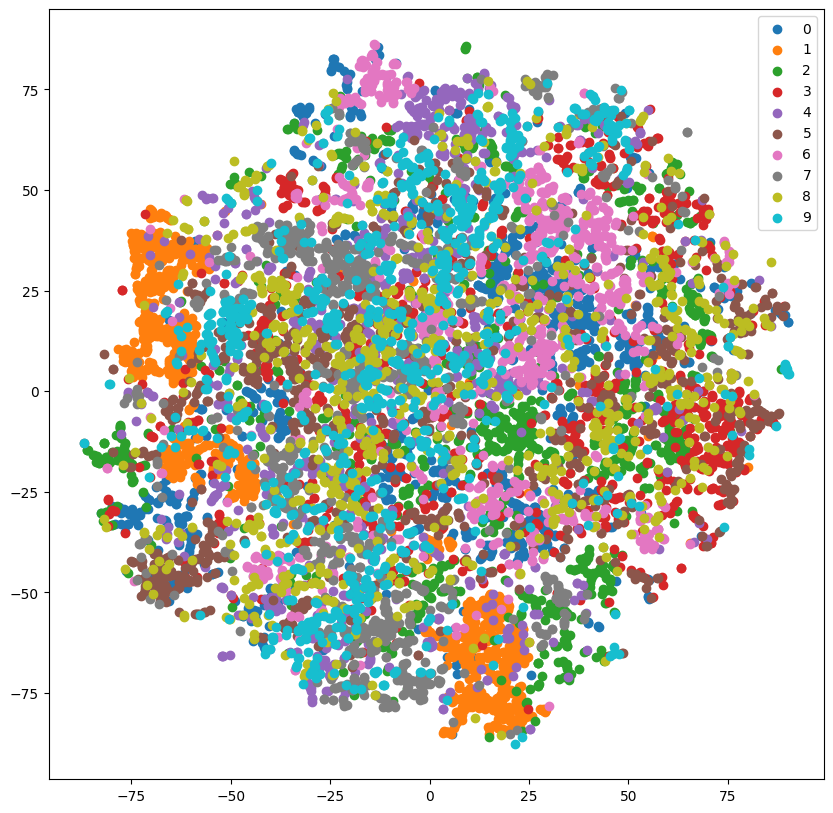

In [71]:
plt.figure(figsize = (10, 10))
for i in range(10):
    plt.scatter(latent_vectors_tsne[colors == i, 0], latent_vectors_tsne[colors == i, 1], label = str(i))
plt.legend()
plt.show()

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

Сильно отличается - latent representation CVAE выглядит намного сложнее: здесь нет четко выделенных классов. Цифра, на которую будет похож output декодера, задается передаваемым туда классом, поэтому в latent representation все не так очевидно, как в предыдущем случае.